In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt
from tcn import TCN

import tensorflow as tf
import keras
from keras import layers
from keras.regularizers import l2
from utils import *

In [2]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :
val :
test :


In [3]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

input_shape = (None, n_frames, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

# Reshape the input to fit the TCN architecture
x = layers.Reshape((n_frames, -1))(x)

# Replace the Conv2Plus1D layers with TCN layers
x = TCN(nb_filters=32, kernel_size=5, dilations=[1, 2, 4], return_sequences=True)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

# Replace the Conv2Plus1D layers with TCN layers
x = TCN(nb_filters=48, kernel_size=5, dilations=[1, 2, 4], return_sequences=True)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(10, kernel_regularizer=l2(0.001))(x)

model = keras.Model(input, x)

frames, label = next(iter(train_ds))
model.build(frames)

class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Stops training when 95% accuracy is reached
    '''
    # Get the current accuracy and check if it is above 95%
    if(logs.get('val_accuracy') > 0.7):

      # Stop training if condition is met
      print("\nThreshold reached. Stopping training...")
      self.model.stop_training = True

# instantiate ES class
early_stopping = EarlyStopping()

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 224, 224, 3)  0         
                             ]                                   
                                                                 
 reshape (Reshape)           (None, 10, 150528)        0         
                                                                 
 tcn (TCN)                   (None, 10, 32)            28927200  
                                                                 
 batch_normalization (BatchN  (None, 10, 32)           128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 10, 32)            0         
                                                                 
 dropout (Dropout)           (None, 10, 32)            0     

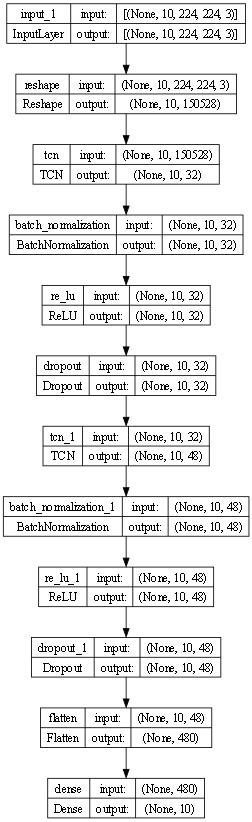

In [4]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [5]:
history = model.fit(x = train_ds,
                    epochs = 100, 
                    validation_data = val_ds)

Epoch 1/100


42/42 [==============================] - 46s 975ms/step - loss: 2.7281 - accuracy: 0.1455 - val_loss: 5.0068 - val_accuracy: 0.1088
Epoch 2/100
42/42 [==============================] - 39s 929ms/step - loss: 2.3910 - accuracy: 0.2364 - val_loss: 3.6848 - val_accuracy: 0.1156
Epoch 3/100
42/42 [==============================] - 39s 939ms/step - loss: 2.3126 - accuracy: 0.2576 - val_loss: 2.4658 - val_accuracy: 0.2449
Epoch 4/100
42/42 [==============================] - 39s 941ms/step - loss: 2.2617 - accuracy: 0.2273 - val_loss: 2.1159 - val_accuracy: 0.2109
Epoch 5/100
42/42 [==============================] - 39s 932ms/step - loss: 2.1999 - accuracy: 0.2727 - val_loss: 2.2117 - val_accuracy: 0.1429
Epoch 6/100
42/42 [==============================] - 39s 936ms/step - loss: 2.1249 - accuracy: 0.3121 - val_loss: 1.9419 - val_accuracy: 0.3810
Epoch 7/100
42/42 [==============================] - 39s 940ms/step - loss: 2.1220 - accuracy: 0.2818 - val_loss: 1.8566 - val_accuracy: 0.4014
Epoc

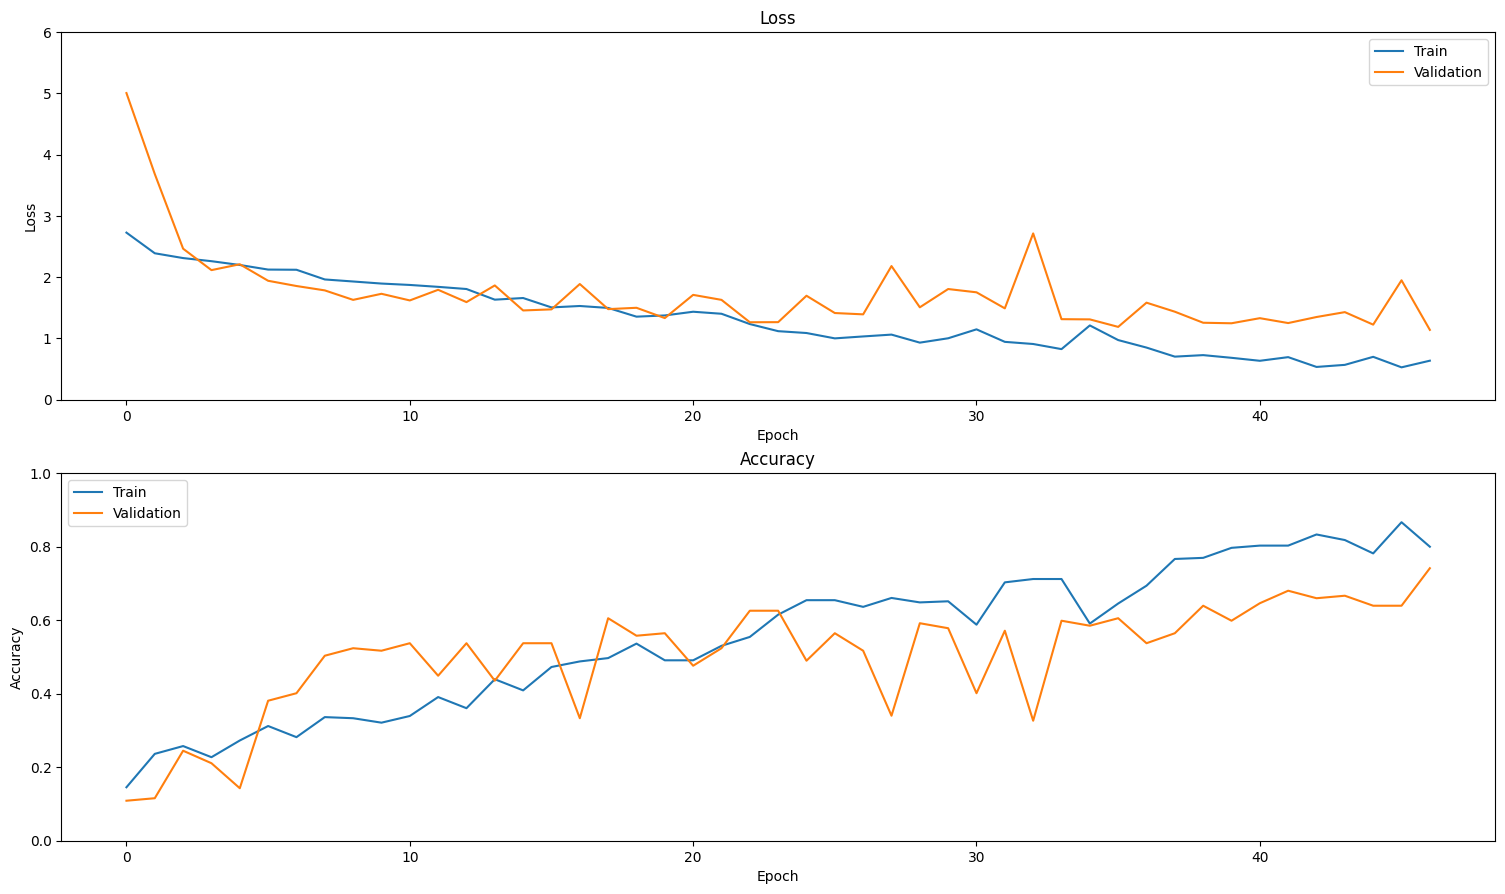

In [6]:
plot_history(history)

In [11]:

model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 8s 593ms/step - loss: 1.1220 - accuracy: 0.6700


{'loss': 1.1220214366912842, 'accuracy': 0.6700000166893005}

In [3]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

NameError: name 'FrameGenerator' is not defined

In [1]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [2]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) 

NameError: name 'actual' is not defined